In [1]:
# If running Python 2.x, makes print and division act like Python 3
from __future__ import print_function, division

# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Enable inline plotting at lower left
%matplotlib inline

from IPython.display import display, Latex, clear_output

In [2]:
import pynrc
from pynrc import nrc_utils          # Variety of useful functions and classes
from pynrc.nrc_utils import S, source_spectrum


# Disable informational messages and only include warnings and higher
pynrc.setup_logging(level='WARN')

[     pynrc:INFO]   jwst_backgrounds is not installed and will not be used for bg estimates.
pyNRC log messages of level WARN and above will be shown.
pyNRC log outputs will be directed to the screen.


In [3]:
# Observation Definitions
from pynrc.nb_funcs import make_key, obs_wfe, obs_optimize
from pynrc.nb_funcs import model_info, disk_rim_model

# Functions to run a series of operations
from pynrc.nb_funcs import do_opt, do_contrast, do_gen_hdus, do_sat_levels

# Plotting routines
from pynrc.nb_funcs import plot_contrasts, plot_contrasts_mjup, planet_mags, plot_planet_patches
from pynrc.nb_funcs import update_yscale, do_plot_contrasts, do_plot_contrasts2
from pynrc.nb_funcs import plot_hdulist, plot_images, plot_images_swlw

# Source Definitions

In [4]:
# Various Bandpasses
bp_v = S.ObsBandpass('v')
bp_k = pynrc.bp_2mass('k')
bp_w1 = pynrc.bp_wise('w1')
bp_w2 = pynrc.bp_wise('w2')

In [5]:
# Science            source,  dist, age, sptype, Teff, [Fe/H], log_g, mag, band
args_sources = [('HD 114174', 26.4, 4000,  'G3IV', 5781, 0.07, 4.51, 5.2, bp_k)]

# References     source,     sptype, Teff, [Fe/H], log_g, mag, band
ref_sources  = [('HD 114174', 'G3IV', 5781, 0.07, 4.51, 5.2, bp_k)]

In [6]:
# Directory housing VOTables 
# http://vizier.u-strasbg.fr/vizier/sed/
votdir = 'votables/'

# Directory to save plots and figures
outdir  = 'outdir/'

In [7]:
# List of filters
args_filter = [('F335M',       'MASK335R',       'CIRCLYOT' ),
               ('F444W',       'MASK335R',       'CIRCLYOT' ),
               ('F210M',       'MASK210R',       'CIRCLYOT' ),
               ('F444W',       'MASKLWB',        'WEDGELYOT'),
              ]


filt_keys = []
for filt,mask,pupil in args_filter:
    filt_keys.append(make_key(filt, mask=mask, pupil=pupil)) 

# SED Fitting

In [8]:
# Fit spectrum to SED photometry
i=0
name_sci, dist_sci, age, spt_sci, Teff_sci, feh_sci, logg_sci, mag_sci, bp_sci = args_sources[i]
vot = votdir + name_sci.replace(' ' ,'') + '.vot'

args = (name_sci, spt_sci, mag_sci, bp_sci, vot)
kwargs = {'Teff':Teff_sci, 'metallicity':feh_sci, 'log_g':logg_sci}
src = nrc_utils.source_spectrum(*args, **kwargs)

src.fit_SED(use_err=True, robust=False)

# Final source spectrum
sp_sci = src.sp_model

[1.03420023]


In [9]:
# Do the same for the reference source
name_ref, spt_ref, Teff_ref, feh_ref, logg_ref, mag_ref, bp_ref = ref_sources[i]
vot = votdir + name_ref.replace(' ' ,'') + '.vot'

args = (name_ref, spt_ref, mag_ref, bp_ref, vot)
kwargs = {'Teff':Teff_ref, 'metallicity':feh_ref, 'log_g':logg_ref}
ref = nrc_utils.source_spectrum(*args, **kwargs)

ref.fit_SED(use_err=True, robust=False)

# Final reference spectrum
sp_ref = ref.sp_model

[1.03420023]


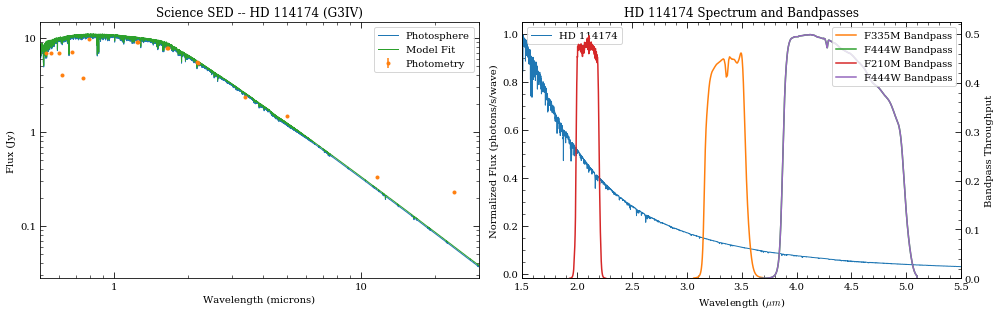

In [10]:
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Plot spectra 
fig, axes = plt.subplots(1,2, figsize=(14,4.5))

ax = axes[0]
src.plot_SED(ax=axes[0], xr=[0.5,30])
ax.set_title('Science SED -- {} ({})'.format(name_sci, spt_sci))
# ax.set_xscale('linear')
# ax.xaxis.set_minor_locator(AutoMinorLocator())


ax = axes[1]
xr = [1.5,5.5]

bp = pynrc.read_filter(*args_filter[-1])
sp = sp_sci
w = sp.wave / 1e4
o = S.Observation(sp, bp, binset=bp.wave)
sp.convert('photlam')
f = sp.flux / sp.flux[(w>xr[0]) & (w<xr[1])].max()

ind = (w>=xr[0]) & (w<=xr[1])
ax.plot(w[ind], f[ind], lw=1, label=sp.name)
ax.set_ylabel('Normalized Flux (photons/s/wave)')
sp.convert('flam')

ax.set_xlim(xr)
ax.set_xlabel(r'Wavelength ($\mu m$)')
ax.set_title('{} Spectrum and Bandpasses'.format(sp_sci.name))

# Overplot Filter Bandpass
ax2 = ax.twinx()
for i, af in enumerate(args_filter):
    bp = pynrc.read_filter(*af)
    ax2.plot(bp.wave/1e4, bp.throughput, color=cols[i+1], label=bp.name+' Bandpass')
ax2.set_ylim([0,ax2.get_ylim()[1]])
ax2.set_xlim(xr)
ax2.set_ylabel('Bandpass Throughput')

ax.legend(loc='upper left')
ax2.legend(loc='upper right')

fig.tight_layout()
#fig.savefig(outdir+'{}_SED.pdf'.format(name_sci.replace(' ','')))


# Initialize Observations

In [11]:
# Create a dictionary that holds the obs_hci class for each filter
wfe_drift = 0
obs_dict = obs_wfe(wfe_drift, args_filter, sp_sci, dist_sci, sp_ref=sp_ref, 
                   wind_mode='WINDOW', verbose=False)


F335M_MASK335R_CIRCLYOT
F444W_MASK335R_CIRCLYOT
F210M_MASK210R_CIRCLYOT
F444W_MASKLWB_WEDGELYOT


In [12]:
# Update multiaccum info
for key in filt_keys:
    obs = obs_dict[key]

    read_mode='MEDIUM8'
    ng, nint_sci, nint_ref = (10,25,25)
    
    obs.update_detectors(read_mode=read_mode, ngroup=ng, nint=nint_sci)
    obs.nrc_ref.update_detectors(read_mode=read_mode, ngroup=ng, nint=nint_ref)

    print(key)
    print(obs.multiaccum_times)
    _ = obs.sensitivity(nsig=5, units='vegamag', verbose=True)
    print('')

F335M_MASK335R_CIRCLYOT
{'t_frame': 1.06904, 't_group': 10.6904, 't_int': 104.76592, 't_exp': 2619.1479999999997, 't_acq': 2646.372, 't_int_tot1': 105.85488, 't_int_tot2': 105.85488}
Point Source Sensitivity (5-sigma): 21.88 vegamag
Surface Brightness Sensitivity (5-sigma): 22.88 vegamag/arcsec^2

F444W_MASK335R_CIRCLYOT
{'t_frame': 1.06904, 't_group': 10.6904, 't_int': 104.76592, 't_exp': 2619.1479999999997, 't_acq': 2646.372, 't_int_tot1': 105.85488, 't_int_tot2': 105.85488}
Point Source Sensitivity (5-sigma): 21.77 vegamag
Surface Brightness Sensitivity (5-sigma): 23.03 vegamag/arcsec^2

F210M_MASK210R_CIRCLYOT
{'t_frame': 4.18584, 't_group': 41.858399999999996, 't_int': 410.21232, 't_exp': 10255.307999999999, 't_acq': 10360.443, 't_int_tot1': 414.41772, 't_int_tot2': 414.41772}
Point Source Sensitivity (5-sigma): 23.90 vegamag
Surface Brightness Sensitivity (5-sigma): 23.63 vegamag/arcsec^2

F444W_MASKLWB_WEDGELYOT
{'t_frame': 1.06904, 't_group': 10.6904, 't_int': 104.76592, 't_exp

## Saturation

In [13]:
sat_dict = {}

for k in filt_keys:
    print('\n{}'.format(k))
    obs = obs_dict[k]
    
    dsat_asec = do_sat_levels(obs, satval=0.9, plot=False)
    sat_dict[k] = dsat_asec


F335M_MASK335R_CIRCLYOT
Sci: HD 114174
  0 saturated pixel at NGROUP=2; Max Well: 0.08
  0 saturated pixel at NGROUP=10; Max Well: 0.44
  Sat Dist NG=2: 0.00 arcsec
Ref: HD 114174
  0 saturated pixel at NGROUP=2; Max Well: 0.08
  0 saturated pixel at NGROUP=10; Max Well: 0.44

F444W_MASK335R_CIRCLYOT
Sci: HD 114174
  0 saturated pixel at NGROUP=2; Max Well: 0.06
  0 saturated pixel at NGROUP=10; Max Well: 0.30
  Sat Dist NG=2: 0.00 arcsec
Ref: HD 114174
  0 saturated pixel at NGROUP=2; Max Well: 0.06
  0 saturated pixel at NGROUP=10; Max Well: 0.30

F210M_MASK210R_CIRCLYOT
Sci: HD 114174
  0 saturated pixel at NGROUP=2; Max Well: 0.88
  418 saturated pixel at NGROUP=10; Max Well: 4.79
  Sat Dist NG=2: 0.00 arcsec
Ref: HD 114174
  0 saturated pixel at NGROUP=2; Max Well: 0.88
  418 saturated pixel at NGROUP=10; Max Well: 4.79

F444W_MASKLWB_WEDGELYOT
Sci: HD 114174
  0 saturated pixel at NGROUP=2; Max Well: 0.03
  0 saturated pixel at NGROUP=10; Max Well: 0.17
  Sat Dist NG=2: 0.00 arc

In [48]:
# Determine contrast curves for various WFE drift values
wfe_list = [0, 2, 5, 10]
#wfe_list = [0, 5, 10]

nsig = 5
roll = 10

curves_dict_ref = do_contrast(obs_dict, wfe_list, filt_keys,
                               nsig=nsig, roll_angle=roll, opt_diff=False, no_ref=False)

F335M_MASK335R_CIRCLYOT
F444W_MASK335R_CIRCLYOT
F210M_MASK210R_CIRCLYOT
F444W_MASKLWB_WEDGELYOT


In [49]:
curves_dict_roll = do_contrast(obs_dict, wfe_list, filt_keys,
                               nsig=nsig, roll_angle=roll, opt_diff=False, no_ref=True)

F335M_MASK335R_CIRCLYOT
F444W_MASK335R_CIRCLYOT
F210M_MASK210R_CIRCLYOT
F444W_MASKLWB_WEDGELYOT


In [50]:
import matplotlib.patches as mpatches

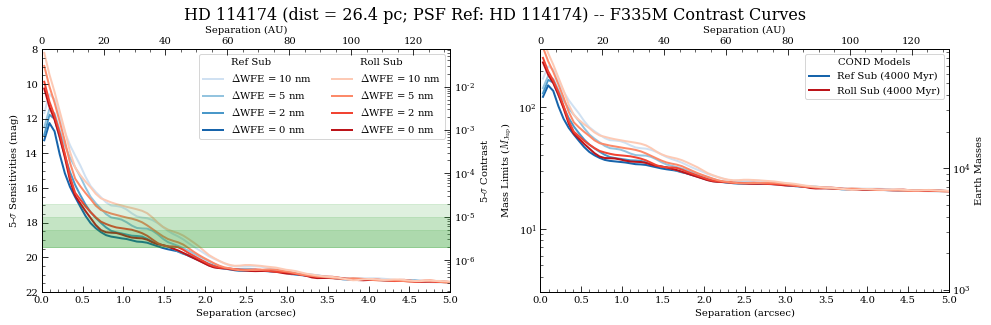

In [54]:
k = filt_keys[0]

curves_ref  = curves_dict_ref[k]
curves_roll = curves_dict_roll[k]
obs = obs_dict[k]
fig, (axes1_all, axes2_all) = do_plot_contrasts(curves_ref, curves_roll, nsig, wfe_list, obs, age, 
                                                xr=[0,5], yr=[22,8], xr2=[0,5], yr2=[3,300], yscale2='log',
                                                return_fig_axes=True)

ax = axes1_all[1]
xlim = ax.get_xlim()
ymin = 2e-6
for ylim in ([ymin, 2e-5], [ymin, 1e-5], [ymin, 5e-6]):
    cols = plt.cm.tab10(np.linspace(0,1,10))
    rect = mpatches.Rectangle((xlim[0], ylim[0]), xlim[1], ylim[1]-ylim[0],
                             alpha=0.15, color=cols[2], zorder=2)
    ax.add_patch(rect)

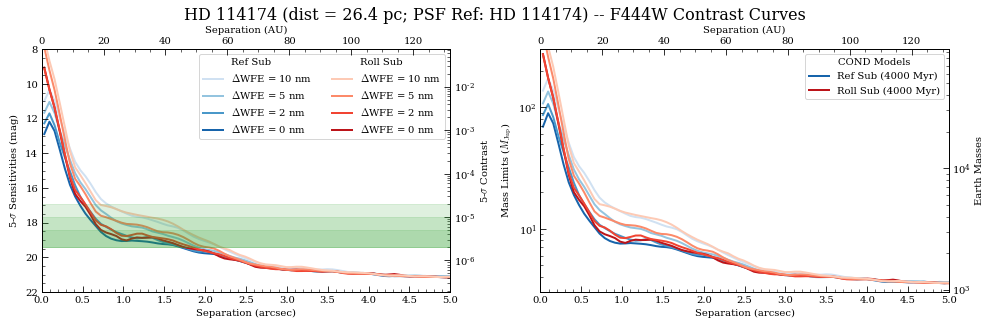

In [26]:
k = filt_keys[1]

curves_ref  = curves_dict_ref[k]
curves_roll = curves_dict_roll[k]
obs = obs_dict[k]
fig, (axes1_all, axes2_all) = do_plot_contrasts(curves_ref, curves_roll, nsig, wfe_list, obs, age, 
                                                xr=[0,5], yr=[22,8], xr2=[0,5], yr2=[3,300], yscale2='log',
                                                return_fig_axes=True)

ax = axes1_all[1]
xlim = ax.get_xlim()
ymin = 2e-6
for ylim in ([ymin, 2e-5], [ymin, 1e-5], [ymin, 5e-6]):
    cols = plt.cm.tab10(np.linspace(0,1,10))
    rect = mpatches.Rectangle((xlim[0], ylim[0]), xlim[1], ylim[1]-ylim[0],
                             alpha=0.15, color=cols[2], zorder=2)
    ax.add_patch(rect)

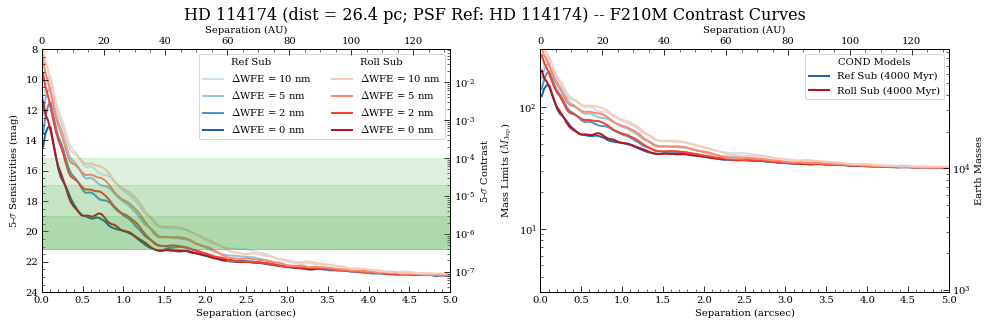

In [59]:
k = filt_keys[2]

curves_ref  = curves_dict_ref[k]
curves_roll = curves_dict_roll[k]
obs = obs_dict[k]
fig, (axes1_all, axes2_all) = do_plot_contrasts(curves_ref, curves_roll, nsig, wfe_list, obs, age, 
                                                xr=[0,5], yr=[24,8], xr2=[0,5], yr2=[3,300], yscale2='log',
                                                return_fig_axes=True)

ax = axes1_all[1]
xlim = ax.get_xlim()
ymin = 4e-7
for ylim in ([ymin, 1e-4], [ymin, 2e-5], [ymin, 3e-6]):
    cols = plt.cm.tab10(np.linspace(0,1,10))
    rect = mpatches.Rectangle((xlim[0], ylim[0]), xlim[1], ylim[1]-ylim[0],
                             alpha=0.15, color=cols[2], zorder=2)
    ax.add_patch(rect)

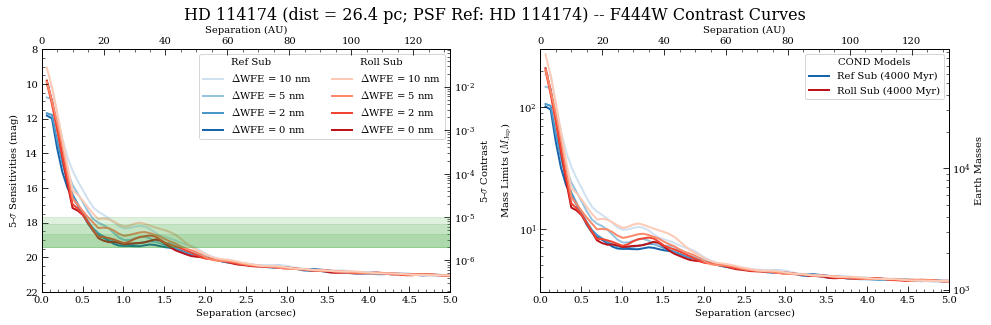

In [57]:
k = filt_keys[3]

curves_ref  = curves_dict_ref[k]
curves_roll = curves_dict_roll[k]
obs = obs_dict[k]
fig, (axes1_all, axes2_all) = do_plot_contrasts(curves_ref, curves_roll, nsig, wfe_list, obs, age, 
                                                xr=[0,5], yr=[22,8], xr2=[0,5], yr2=[3,300], yscale2='log',
                                                return_fig_axes=True)

ax = axes1_all[1]
ymin = 2e-6
for ylim in ([ymin, 1e-5], [ymin, 7e-6], [ymin, 4e-6]):
    cols = plt.cm.tab10(np.linspace(0,1,10))
    rect = mpatches.Rectangle((xlim[0], ylim[0]), xlim[1], ylim[1]-ylim[0],
                             alpha=0.15, color=cols[2], zorder=2)
    ax.add_patch(rect)

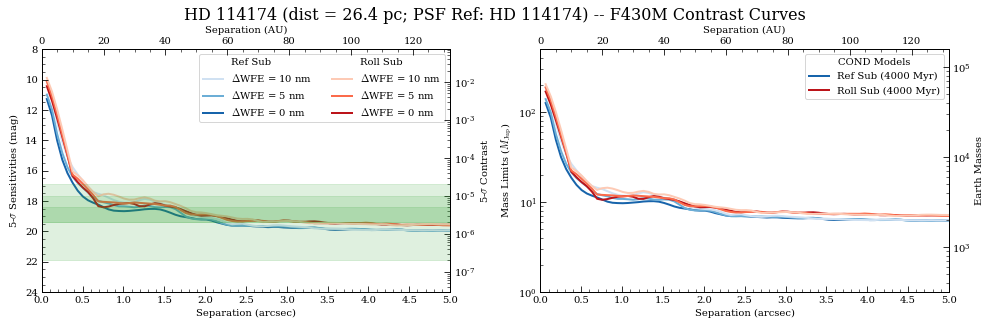

In [17]:
k = filt_keys[3]

curves_ref  = curves_dict_ref[k]
curves_roll = curves_dict_roll[k]
obs = obs_dict[k]
fig, (axes1_all, axes2_all) = do_plot_contrasts(curves_ref, curves_roll, nsig, wfe_list, obs, age, 
                                                xr=[0,5], yr=[24,8], xr2=[0,5], yr2=[1,500], yscale2='log',
                                                return_fig_axes=True)

ax = axes1_all[1]
xlim = ax.get_xlim()
for ylim in ([2e-7, 2e-5], [2e-6, 1e-5], [2e-6, 5e-6]):
    cols = plt.cm.tab10(np.linspace(0,1,10))
    rect = mpatches.Rectangle((xlim[0], ylim[0]), xlim[1], ylim[1]-ylim[0],
                             alpha=0.15, color=cols[2], zorder=2)
    ax.add_patch(rect)

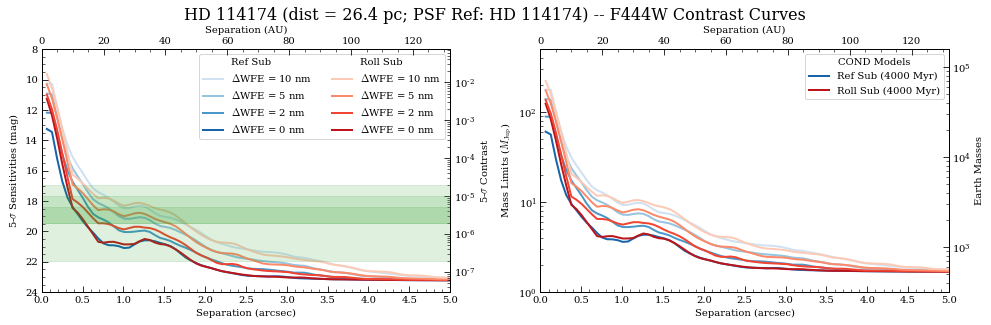

In [19]:
k = 'F444W_MASKLWB_WEDGELYOT'
curves_ref  = curves_dict_ref[k]
curves_roll = curves_dict_roll[k]
obs = obs_dict[k]
fig, (axes1_all, axes2_all) = do_plot_contrasts(curves_ref, curves_roll, nsig, wfe_list, obs, age, 
                                                xr=[0,5], yr=[24,8], xr2=[0,5], yr2=[1,500], yscale2='log',
                                                return_fig_axes=True)

ax = axes1_all[1]
xlim = ax.get_xlim()
for ylim in ([2e-7, 2e-5], [2e-6, 1e-5], [2e-6, 5e-6]):
    cols = plt.cm.tab10(np.linspace(0,1,10))
    rect = mpatches.Rectangle((xlim[0], ylim[0]), xlim[1], ylim[1]-ylim[0],
                             alpha=0.15, color=cols[2], zorder=2)
    ax.add_patch(rect)

In [47]:
nrc1 = obs_dict['F444W_MASKLWB_WEDGELYOT']

In [30]:
nrc2 = obs_dict['F444W_MASKLWB_WEDGELYOT']

In [54]:
psf1 = nrc1.gen_psf(use_bg_psf=False)
psf2 = .gen_psf(use_bg_psf=False)

In [55]:
psf1.sum()

0.0003405035011725703

In [56]:
nrc_utils.pad_or_cut_to_size(psf2,33).sum()

0.0003455043975508199

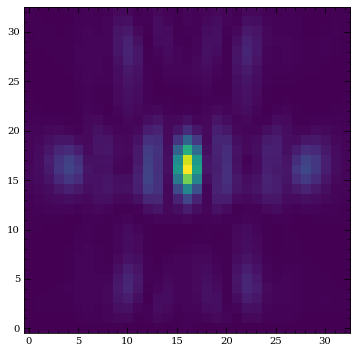

In [51]:
plt.imshow(psf1)

In [36]:
inst = nrc_utils.webbpsf_NIRCam_mod()

In [57]:
from webbpsf.webbpsf_core import poppy
import os
from astropy.io import fits
def get_wave(inst, wfe_drift, bar_offset, w=4.0, fov_pix=160, oversample=2):

    inst.filter = 'F405N'
    inst.image_mask = 'MASKLWB'
    inst.pupil_mask = 'WEDGELYOT'
    inst.include_si_wfe = False
    inst.options['jitter'] = None
    inst.options['jitter_sigma'] = 0
    
    # Bar offset
    inst.options['bar_offset'] = bar_offset

    inst.SHORT_WAVELENGTH_MIN = inst.LONG_WAVELENGTH_MIN = 1e-7
    inst.SHORT_WAVELENGTH_MAX = inst.LONG_WAVELENGTH_MAX = 10e-6

    # Base OPD
    opd = nrc_utils.opd_default
    opd_name = opd[0] # OPD file name
    opd_num  = opd[1] # OPD slice
    opd_im, header = pynrc.speckle_noise.read_opd_slice(opd, header=True)

    # OPD drift
    opd_dir = os.path.join(nrc_utils.conf.PYNRC_PATH, 'opd_mod/')
    drift_file = 'wfedrift_case1_var2.fits'
    delta_hdul = fits.open(opd_dir + drift_file)
    delta_rms = delta_hdul[0].header['RMS_WFE']
    scale_val = wfe_drift / delta_rms

    delta_data = delta_hdul[0].data * scale_val
    delta_hdul.close()

    opd_im += delta_data
    hdu = fits.PrimaryHDU(opd_im)
    hdu.header = header

    hdu.header.add_history("Modified OPD by adding delta")
    hdu.header.add_history(" from " + drift_file)
    hdu.header.add_history(" scaled by {}".format(scale_val))

    hdu.header['ORIGINAL'] = (opd_name,   "Original OPD source")
    hdu.header['SLICE']    = (opd_num,    "Slice index of original OPD")
    hdu.header['DFILE']    = (drift_file, "Source file for OPD drift")
    hdu.header['OCASE']    = (delta_hdul[0].header['CASE'], "Oscillation model case")
    hdu.header['OVARIANT'] = (delta_hdul[0].header['VARIANT'],
                                         "Oscillation model variant")
    hdu.header['OAMP']     = (scale_val, "Amplitude scale factor")
    hdu.header['WFEDRIFT'] = (wfe_drift, "WFE drift amount [nm]")

    opd_hdulist = fits.HDUList([hdu])
    inst.pupilopd = opd_hdulist

    # No multiprocessing for monochromatic wavelengths
    mp_prev = poppy.conf.use_multiprocessing
    poppy.conf.use_multiprocessing = False
    hdu_list = inst.calc_psf(fov_pixels=fov_pix, oversample=oversample, monochromatic=w*1e-6,
                             add_distortion=False, crop_psf=True)
    poppy.conf.use_multiprocessing = mp_prev
    
    return hdu_list[0]

In [122]:
wfe_list = [0,2,5,10,20]
bar_list = np.arange(-8,8,2)

nwfe = len(wfe_list)
nbar = len(bar_list)

In [60]:
fov_pix=160
oversample=2

all_psf = []
for wfe in wfe_list:
    print(wfe)
    for boff in bar_list:
        hdu = get_wave(inst, wfe, boff, w=4.0, fov_pix=fov_pix, oversample=oversample)
        all_psf.append(hdu.data)
        
all_psf = np.array(all_psf)

0
2
5
10
20


In [110]:
all_psf = all_psf.reshape(len(wfe_list), len(bar_list), fov_pix*oversample, -1)

In [111]:
all_psf.shape

(5, 8, 320, 320)

In [114]:
diff = all_psf[0,0,:,:] - all_psf[2,0,:,:]

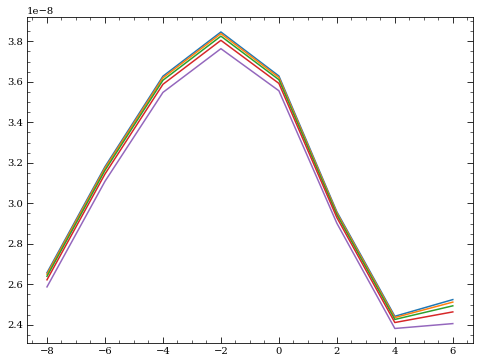

In [129]:
for i in range(nwfe):
    plt.plot(bar_list, all_psf[i,:,100,140])#-all_psf[i,0,100,140])

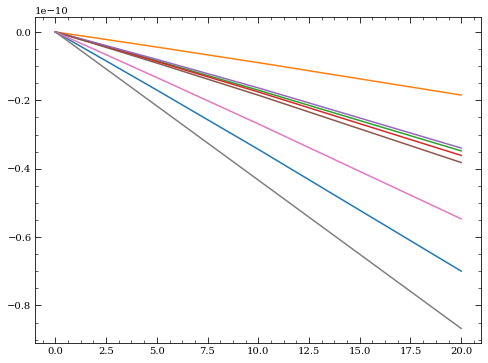

In [133]:
xpix, ypix = (100,100)
for i in range(nbar):
    plt.plot(wfe_list, all_psf[:,i,xpix,ypix]-all_psf[0,i,xpix,ypix])

In [ ]:
for psf in all_psf:
    diff = psf - all_psf[0]
    print(np.std(diff))

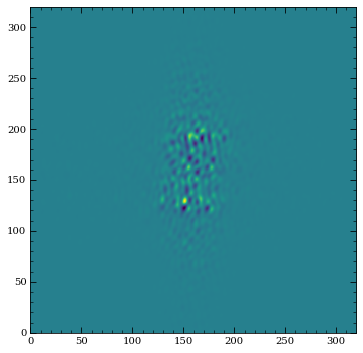

In [93]:
plt.imshow(all_psf[9] - all_psf[1])

In [87]:
len(bar_list)

8